In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import torch
import numpy as np
import imageio
import os
import csv
import torch.optim as optim
import torch.nn as nn
from collections import OrderedDict

# 6장 - 신경망을 활용한 데이터 적합

In [2]:
# 5장은 단순한 예제로 모델의 학습 방법에 집중했음
# 6장은 모델 아키텍처를 바꿔 온도 변환 문제를 풀기 위한 완전한 인공 신경망을 구현할 것
# 이번 장에서는 지금까지 다룬 기본 작업들을 프로젝트 수행할 때마다 사용할 파이토치의 기능으로 구현할 것
# 먼저 인공 신경망(artificial neural network)이라는 용어 확인

## 1절 - 인공 뉴런

In [3]:
# 신경망은 복잡한 함수를 단순한 함수들의 합성으로 표현할 수 있는 수학적 엔티티
# 초기 모델은 신경과학 분야 영향을 받았으나 현재에는 뉴런의 동작과는 조금만 비슷함
# 인공 신경망과 사람의 신경망은 복잡한 함수에 근사하기 위해 어느 정도 유사한 수학적 접근을 보이며 이 전략은 효과적으로 동작함

In [4]:
# 이 복잡한 함수의 기본 빌딩 블럭은 뉴런임
# 본질적으로 뉴런은 단순히 입력에 대한 선형 변환(입력에 가중치 곱하고 편향치 더하기)과 활성 함수(activation function)라 부르는 고정된 비선형 함수를 적용하는 역할

In [5]:
# 수학적으로 o = f(w * x + b)로 표현 가능
# 일반적으로 x, o는 단순 스칼라값 혹은 벡터이고, w 는 단일 스칼라 혹은 행렬, b는 스칼라나 벡터(입력 및 가중치와 차원 일치)
# 벡터의 경우엔 여러 차원으로 가중치와 편향값을 가진 여러 개의 뉴런을 나타내므로 뉴런 계층(layer)이라 함

In [6]:
# 다중 계층 신경망은 함수들의 합성으로 만들어짐
# 여러 뉴런으로 구성된 계층의 출력을 이어지는 다음 계층의 입력으로 사용

In [7]:
# 선형 모델과 딥러닝과의 주요한 차이점 중 하나는 오차 함수의 모양임
# 선형 모델과 오차 제곱한 손실 함수는 볼록 함수 형태의 오차 곡선 가지므로 최솟값이 하나로 정의됨
# 즉 파라미터 조정이 하나의 정답에 가까워지도록 값을 추정함

In [8]:
# 신경망은 오차 제곱 손실 함수 사용해도 볼록 함수의 오차 곡선의 모양이 다름
# 파라미터는 정해진 답없이 뉴런들이 협력하여 유용한 출력(참값에 근사) 만들기 위한 파라미터 획득을 목표로 함
# 신경망 훈련이 기계적 파라미터 추정과 유사해 보이지만 이론적 기반이 전혀 다름

In [9]:
# 신경망의 오차 함수가 볼록 형태가 아닌 이유는 활성 함수 때문
# 매우 다양한 함수에 근사할 수 있는 뉴런의 능력은 각각 내포하는 선형과 비선형적 조합 덕분

In [10]:
# 활성 함수의 두 가지 중요한 역할
# 1. 모델 내부에서 출력 함수가 값마다 다른 기울기 가지도록 만들기
#    여러 출력에 대해 각기 기울기가 다른 특성을 합성하여 임의의 함수에 근사할 수 있게 됨
# 2. 신경망의 마지막 계층은 이전의 선형 연산 출력을 주어진 범위로 모으는 역할

In [11]:
# 선형 연산의 출력을 특정 범위로 제한하여 출력을 사용하는 곳에서 별도 처리하는 경우가 없게 해야 됨
# 출력값을 제한하는 방법으로 0 이하는 0, 10 이상은 10으로 두기 -> torch.nn.Hardtanh(기본값은 -1 ~ 1)에서 구현

In [12]:
# Hardtanh와 유사하며 잘 동작하는 함수로 torch.nn.Sigmoid
# 시그모이드 함수화 torch.tanh 등이 포함됨
# 음수로 가면 0이나 -1에 수렴, 양수로 가면 1에 수렴하며 x == 0 일 때 상수 기울기를 가짐
# 뉴런이 민감하게 반응하는 함수의 중앙 영역에 선형 함수가 존재하고 다른 영역은 경계값에 가까워지기 때문에 개념적으로 잘 작동함

In [13]:
import math
print(math.tanh(-2.2))
print(math.tanh(0.1))
print(math.tanh(2.5))

-0.9757431300314515
0.09966799462495582
0.9866142981514303


In [14]:
# 그 외 활성 함수
# 매끄러운 함수(smooth function)인 Tanh, softplus, 각진 함수(hard function)인 Hardtanh, ReLU
# 시그모이드는 로지스틱 함수라고도 하는데 초기 딥러닝에서 많이 사용했지만 출력값이 확률적일 때 값을 0~1 사이로 옮기는 경우 외에는 많이 사용하지 않음

In [15]:
# 어떤 경우에는 명백히 틀렸다고 입증될 수 있지만 일반적인 활성 함수의 특성
# 비선형성(활성 함수 없이 반복해서 적용하면 동일한(아핀 선형) 형태의 함수가 됨) 활성 함수의 비선형성이 전체 신경망이 더 복잡한 함수로 근사하도록 해주는 역할
# 미분 가능(기울기 계산이 가능 Hardtanh나 ReLU에서의 불연속점은 큰 문제 안 됨)

In [16]:
# 활성 함수에 대해 맞는 말
# 최소한 하나의 민감한 구간을 가지며 입력에서 중요 범위가 변경되면 일치하는 출력 영역에서도 중요한 변화 발생(이 부분이 훈련에서 필요한 구간)
# 대부분이 둔감한(포화된) 구간을 가지며 이 구간에서는 입력의 변화가 출력에 거의 영향 미치지 못함

In [17]:
# 일반적으로 활성 함수는 아래 특징 중 하나를 가짐
# 입력이 음의 무한대로 갈 때 만나거나 가까워지는 저점 있음
# 양의 무한대로 갈 때 고점 있음

In [18]:
# 역전파 과정을 생각하면 입력이 응답 범위에 있을 때 오차가 활성 단계를 통해 더 효과적으로 역방향으로 전파되야 함을 이해할 수 있음
# 반대로 입력이 포화된 경우(출력값의 평평한 부분으로 인해 기울기가 0에 가까운 상황)에는 오차가 뉴런에 큰 영향을 미치지 않아야 함

In [19]:
# 선형 및 활성화 유닛으로 만들어진 신경망에 다른 입력이 들어오는 경우
# 1. 같은 입력이라도 반응하는 유닛이 다르고 각 유닛 별로 다른 범위로 반응
# 2. 학습 과정에서도 다른 유닛은 영향받지 않고 입력에 대해 민감 범위를 가지고 있는 관련된 유닛만 오차값에 의해 영향 받음
# 부가적으로 입력에 대해 활성화된 곳에서의 미분은 1에 가까운 값을 가지는 경우가 빈번한데 이런 성질을 통해 반응하는 유닛의 범위로부터 경사 하강으로 선형 변환식의 파라미터 추정 가능

In [20]:
# 유닛 조합법에 따라 입력에 대해 다른 범위로 응답하며 유닛들이 가지는 파라미터의 최적화는 출력값이 포화될 때까지 선형 함수의 학습처럼 동작하므로 쉽게 경사 하강으로 최적화됨

In [21]:
# 선형 변환을 스택처럼 쌓아 만든 빌딩 블럭에 미분 가능한 활성 함수 연결한 모델은 고차원의 비선형 작업에도 근사하며 파라미터도 경사 하강을 통해 꽤 잘 추정 가능
# 데이터를 표현하는 정확한 함수에 대해 크게 고민할 필요 없음
# 심층 신경망 모델은 범용의 근사 함수와 파라미터 추정 수단
# 근사 함수는 필요에 따라 단순 빌딩 블럭을 구성하는 것만으로 모델의 용량이나 복잡한 입출력 관계를 모델링하도록 커스터마이징 가능

In [22]:
# 심층 신경망은 훈련되지 않은 일반 모델에서 출발해 입출력쌍 예제와 역전파할 손실 함수를 제공받아 특정 작업에 최적화함
# 예제를 통해 일반 모델을 최적화하는 과정을 학습(learning)이라고 함

In [23]:
# 심층 신경망은 충분히 다양한 입출력 관계에 대해 근사할 수있는 함수군으로 구성되어 복잡 미묘한 문제들을 다룰 수 있는지를 생각함
# 명시적인 모델을 사람이 직접 만드는 데에는 한계가 있으므로 심층 신경망과 같이 데이터에 기반한 방법 외에는 풀 방법이 없음

## 2절 - 파이토치 nn 모듈

In [24]:
# 신경망을 만드는 첫 단계는 선형 모델을 신경망 유닛으로 바꾸는 것
# 파이토치에는 torch.nn이라는 신경망 전용 서브 모듈 존재
# 이 모듈에는 모든 신경망 아키텍처를 만들 수 있는 빌딩블럭(=모듈, module(=계층, layer)) 존재
# 모듈은 하나 이상의 parameter 객채를 텐서 타입의 인자를 받고 훈련 과정을 통해 값을 최적화 함
# 모듈은 다시 하나 이상의 서브 모듈을 속성으로 가지며 파라미터 추적이 가능

In [25]:
# nn.Module에 있는 nn.Linear 서브 클래스로 5장 코드에 (weight와 bias를 통해) 입력에 대한 아핀(Affine) 변환 적용하기

In [26]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1)
t_u = torch.tensor(t_u).unsqueeze(1)

n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

In [27]:
# nn.Module의 모든 서브클래스에 정의된 __call__메소드로 nn.Linear를 인스턴스화하여 함수인 것처럼 실행
import torch.nn as nn

linear_model = nn.Linear(1, 1)
linear_model(t_un_val)

tensor([[4.0992],
        [3.9428]], grad_fn=<AddmmBackward0>)

In [28]:
# 인자를 가지고 nn.Module 인스턴스 호출하면 동일한 인자로 forward 호출함
# forward 메소드는 순방향 연산 수행하는 반면 __call__은 forward를 호출 전후로 중요 작업 수행
# 따라서 forward 직접 호출할 수 있고 __call__과 같은 결과 얻을 수 있으나 유저 코드에서는 사용하지 않는 편이 좋음
# y = model(x) # 옳은 방법
# y = model.forward(x) # 티 안나는 오류 비추

In [29]:
# Module.__call__의 구현
def __call__(self, *input, **kwargs):
    for hook in self._forward_pre_hooks.values():
        hook(self, input)

    result = self.forward(*input, **kwargs)

    for hook in self._forward_hooks.values():
        hook_result = hook(self, input, result)
        # ...

    for hook in self._backward_hooks.values():
        ""
        #...

    return result

In [30]:
# 위 코드와 같이 .forward(...) 호출하면 제대로 수행되지 않을 훅 존재

In [31]:
# nn.Linear 생성자는 입력 피처의 수와 출력 피처의 수와 선형 모델이 편향값 포함하는지의 여부(default=True)의 세 개의 인자 존재
import torch.nn as nn

linear_model = nn.Linear(1, 1) # 입력 크기 1, 출력 크기 1, 편향값 default=True
linear_model(t_un_val)

tensor([[-4.8457],
        [-4.6294]], grad_fn=<AddmmBackward0>)

In [32]:
# 피처 수는 모듈에 대한 입출력 텐서 크기와 같아 값이 1, 1임
# 입력이 온도와 입력이면 입력 피처 2, 출력 피처 1
# 중간 규모의 모듈을 가진 복잡한 모델을 다루게 되면 피처의 수는 모델의 용량과 연관 있음을 알게 됨

In [33]:
# 하나의 입력 피처와 하나의 출력 피처를 가진 nn.Linear 인스턴스는 하나의 가중치와 편향값 요구
print(linear_model.weight, linear_model.bias)

Parameter containing:
tensor([[-0.9402]], requires_grad=True) Parameter containing:
tensor([0.6265], requires_grad=True)


In [34]:
# 입력값으로 모듈 호출
x = torch.ones(1)
linear_model(x)

tensor([-0.3138], grad_fn=<ViewBackward0>)

In [35]:
# 이 모델은 입출력이 1씩이지만 nn.Moduel과 서브클래스들은 여러 개의 샘플을 다루도록 설계됨
# 여러 샘플들을 수용하기 위해 모듈 입력의 0번째 차원은 배치에 들어있는 샘플의 수라고 생각

In [36]:
# nn에 있는 모든 모듈은 한 번에 여러 입력을 가진 배치에 대한 출력을 만들도록 작성됨

In [37]:
# 10개의 샘플에 대해 nn.Linear 실행
x = torch.ones(10, 1)
linear_model(x)

tensor([[-0.3138],
        [-0.3138],
        [-0.3138],
        [-0.3138],
        [-0.3138],
        [-0.3138],
        [-0.3138],
        [-0.3138],
        [-0.3138],
        [-0.3138]], grad_fn=<AddmmBackward0>)

In [38]:
# 배치 수행하는 이유
# 연산량을 충분히 크게 만들어 준비한 자원을 최대한 활용하기 위함
# ㄴ병렬 연산에 최적화된 GPU에 작은 모델 넣고 입력 하나 수행하면 나머지 자원이 놀게 되므로 다른 유닛도 계산에 사용하게 만들어 걸리는 시간 단축
# 어떤 고급 모델은 전체 배치에 대해 통계 정보를 사용하는데 배치 사이즈가 클수록 더 나은 통계값 얻음

In [39]:
# 온도계 데이터에서 입력 피처가 하나라서 브로딩캐스트를 통해 w * x + b 사용 가능
# 입력 피처가 두 개였다면 행에는 샘플이 있고 열에는 피처가 있는 행렬로 바꾸기 위한 1차원 텐서가 추가로 필요했을 것

In [40]:
# nn.Linear 사용
# B개의 입력을 B * Nin으로 리셰이프하면 되고 Nin=1 임
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1)
t_u = torch.tensor(t_u).unsqueeze(1)

t_u.shape

torch.Size([11, 1])

In [41]:
# 학습 코드 업데이트
# 작성한 모델을 nn.Linear(1, 1)로 변경 후 옵티마이저에 선형 모델 파라미터 전달
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

In [42]:
linear_model.parameters()

<generator object Module.parameters at 0x7feebc444740>

In [43]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[0.5016]], requires_grad=True),
 Parameter containing:
 tensor([-0.0419], requires_grad=True)]

In [44]:
# parameters 메소드 호출 시, 모듈의 init 생성자에 정의된 서브 모듈까지 재귀적으로 호출하며 만나는 모든 파라미터 리스트를 담은 리스트 반환

In [45]:
# 옵티마이저에는 텐서 리스트 전달, 텐서는 parameters 가지며 경사 하강으로 최적화 될 예정이므로 requires_grad=True를 기본으로 가짐
# training_loss.backward() 호출되면 옵티마이저에 전달된 grad가 그래프의 말단 노드들에 누적
# optimizer.step()이 호출되면 각 Parameter 순회하며 grad 속성에 저장된 비율만큼 값 조정

In [46]:
# 훈련 루프 확인
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val, t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train)
        loss_train = loss_fn(t_p_train, t_c_train)

        t_p_val = model(t_u_val)
        loss_val = loss_fn(t_p_val, t_c_val)

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")

In [47]:
# torch.nn에는 일반적인 손실 함수가 있음
# 평균제곱오차(Mean Square Error, MSE)는 nn.MSELoss로 사용되며 앞에서 정의한 loss_fn과 동일
# nn에 포함된 손실 함수는 nn.Module의 서브 클래스이므로 인스턴스 만들어 함수처럼 호출하면 됨

In [48]:
# loss_fn 변경
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(n_epochs = 3000, optimizer=optimizer, model=linear_model, loss_fn=nn.MSELoss(), t_u_train=t_un_train, t_u_val=t_un_val, t_c_train=t_c_train, t_c_val=t_c_val)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 276.6655, Validation loss 331.3967
Epoch 1000, Training loss 3.6904, Validation loss 2.2564
Epoch 2000, Training loss 3.1947, Validation loss 2.2071
Epoch 3000, Training loss 3.1869, Validation loss 2.2012

Parameter containing:
tensor([[5.3078]], requires_grad=True)
Parameter containing:
tensor([-17.2604], requires_grad=True)


## 3절 - 드디어 신경망

In [49]:
# 선형 모델 대신 신경망을 근사 함수로 바꾸기

In [50]:
# model만 다시 정의
# 선형 모듈 뒤에 활성 함수 달고 다른 선형 모듈에 연결

In [51]:
# nn.Sequential 컨테이너를 통해 모듈을 간단하게 결합할 수 있음
seq_model = nn.Sequential(nn.Linear(1, 13),
                          nn.Tanh(),
                          nn.Linear(13, 1))
seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

In [52]:
# 모델의 첫 번째 모듈은 nn.Sequential의 첫 번째 인자
# 모듈의 중간 출력은 이어지는 다른 모듈에 전달되며 마지막 모듈에 의해 출력이 만들어짐

In [53]:
# model.parameters() 호출하면 첫 번째와 두 번째 선형 모듈에서 weight와 bias를 모음
[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

In [54]:
# model.backward() 호출하면 grad에서 파라미터 추출되고 optimizer.step() 호출 과정에서 적절하게 파라미터 값을 조정

In [55]:
# 여러 개의 서브 모듈로 만들어진 모델의 파라미터 추적하는 경우, 파라미터를 이름으로 식별가능하게 하면 편리함 -> named_parameters 메소드
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


In [56]:
# Sequential의 각 모듈 이름은 인자에서 모듈이 나타난 순서를 따름
# Sequential은 OrderedDict라는 인자로 모듈의 이름을 정해서 전달해도 됨
from collections import OrderedDict
seq_model = nn.Sequential(OrderedDict([('hidden_linear', nn.Linear(1, 8)),
                                       ('hidden_activation', nn.Tanh()),
                                       ('output_linear', nn.Linear(8, 1))]))

seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

In [57]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


In [58]:
# 서브 모듈을 속성처럼 사용해 특정 Parameter에 접근
seq_model.output_linear.bias

Parameter containing:
tensor([-0.0243], requires_grad=True)

In [59]:
# 파라미터 추적이나 기울기 파악에 유용한 방법
# 은닉층의 선형 영역에서 weight의 기울기를 출력하기
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)

training_loop(n_epochs = 5000,
              optimizer = optimizer,
              model = seq_model,
              loss_fn = nn.MSELoss(),
              t_u_train = t_un_train,
              t_u_val = t_un_val,
              t_c_train = t_c_train,
              t_c_val = t_c_val)

print('output', seq_model(t_un_val))
print('answer', t_c_val)
print('hidden', seq_model.hidden_linear.weight.grad)

Epoch 1, Training loss 194.9454, Validation loss 229.3918
Epoch 1000, Training loss 6.9939, Validation loss 2.3190
Epoch 2000, Training loss 2.8798, Validation loss 11.0652
Epoch 3000, Training loss 1.1892, Validation loss 7.9126
Epoch 4000, Training loss 0.9711, Validation loss 7.9049
Epoch 5000, Training loss 0.9068, Validation loss 8.6656
output tensor([[12.3461],
        [10.7923]], grad_fn=<AddmmBackward0>)
answer tensor([[15.],
        [14.]])
hidden tensor([[ 0.0093],
        [-0.0157],
        [ 0.0209],
        [ 0.0304],
        [-0.0121],
        [ 0.0106],
        [-0.0007],
        [-0.0717]])


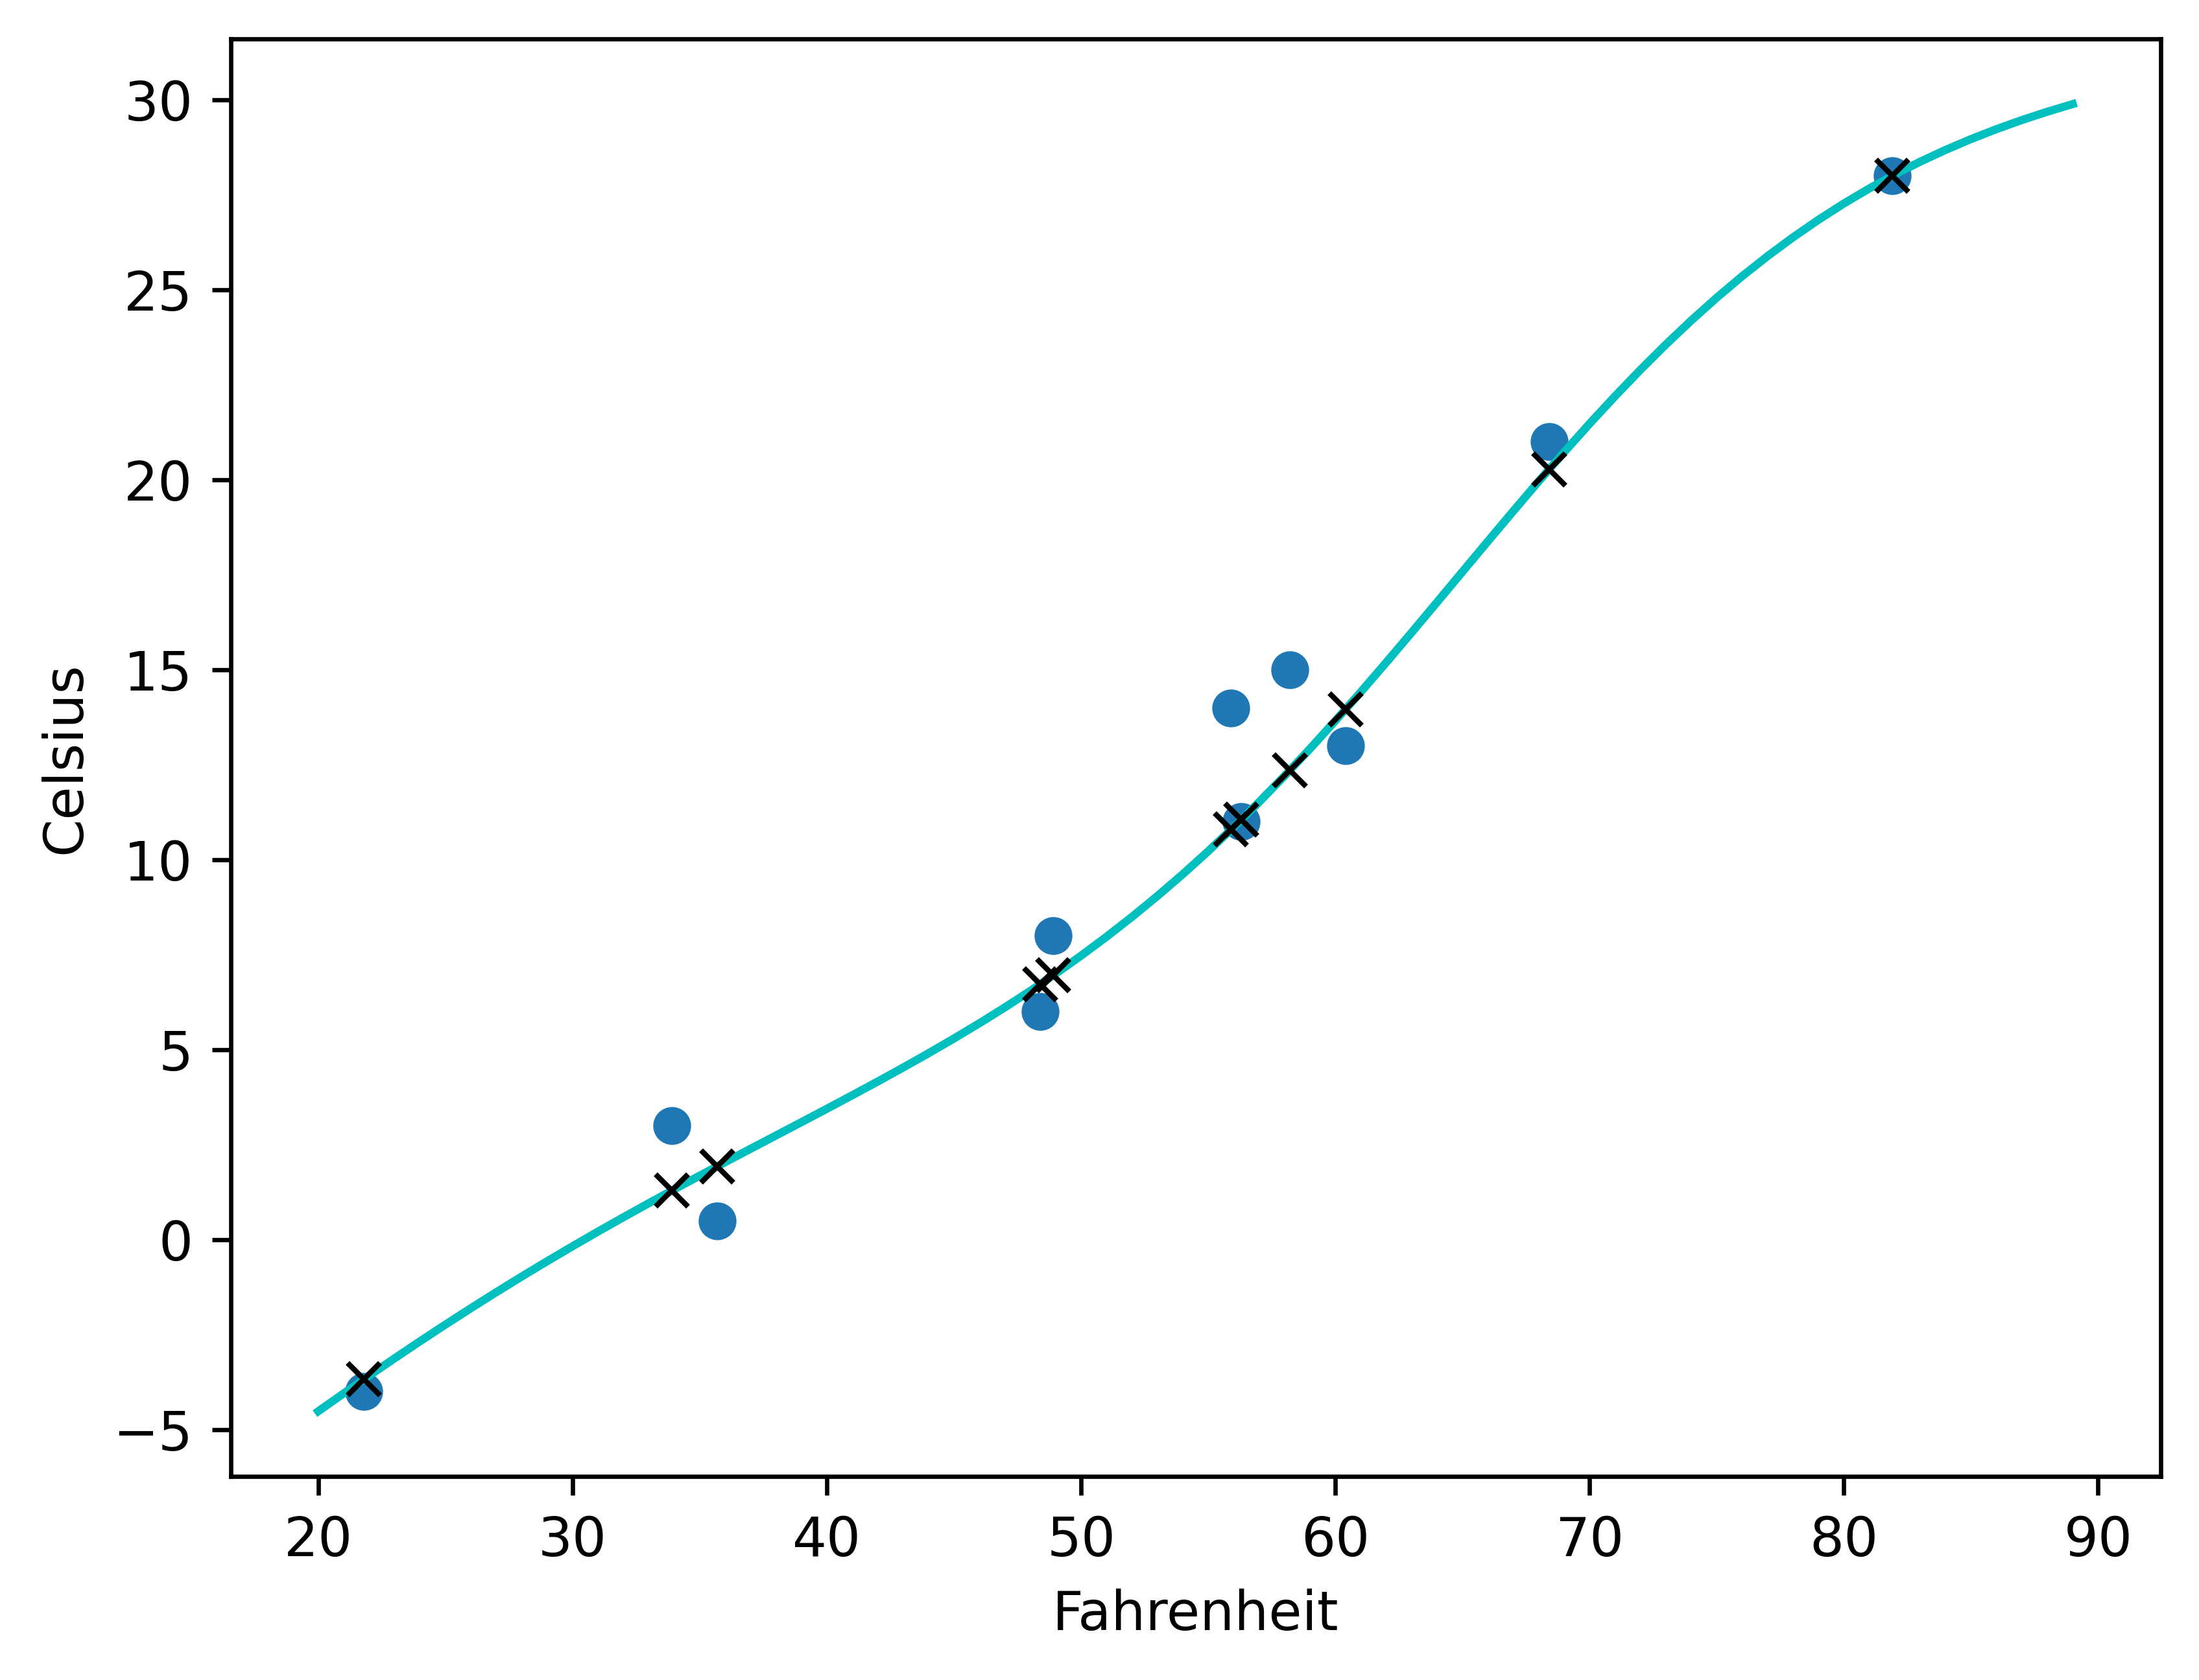

In [60]:
# 위 모델과 선형과의 차이점 확인
t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=600)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')

## 4절 - 결론

In [61]:
# 미분 가능한 모델을 만들고 경사 하강을 통해 자동미분, nn으로 훈련 진행했음

## 5절 - 연습 문제

Epoch 1, Training loss 210.9437, Validation loss 28.0473
Epoch 1000, Training loss 8.2926, Validation loss 0.0767
Epoch 2000, Training loss 6.9436, Validation loss 0.4165
Epoch 3000, Training loss 4.1704, Validation loss 1.0064
Epoch 4000, Training loss 2.8249, Validation loss 2.0194
Epoch 5000, Training loss 2.0536, Validation loss 2.9934


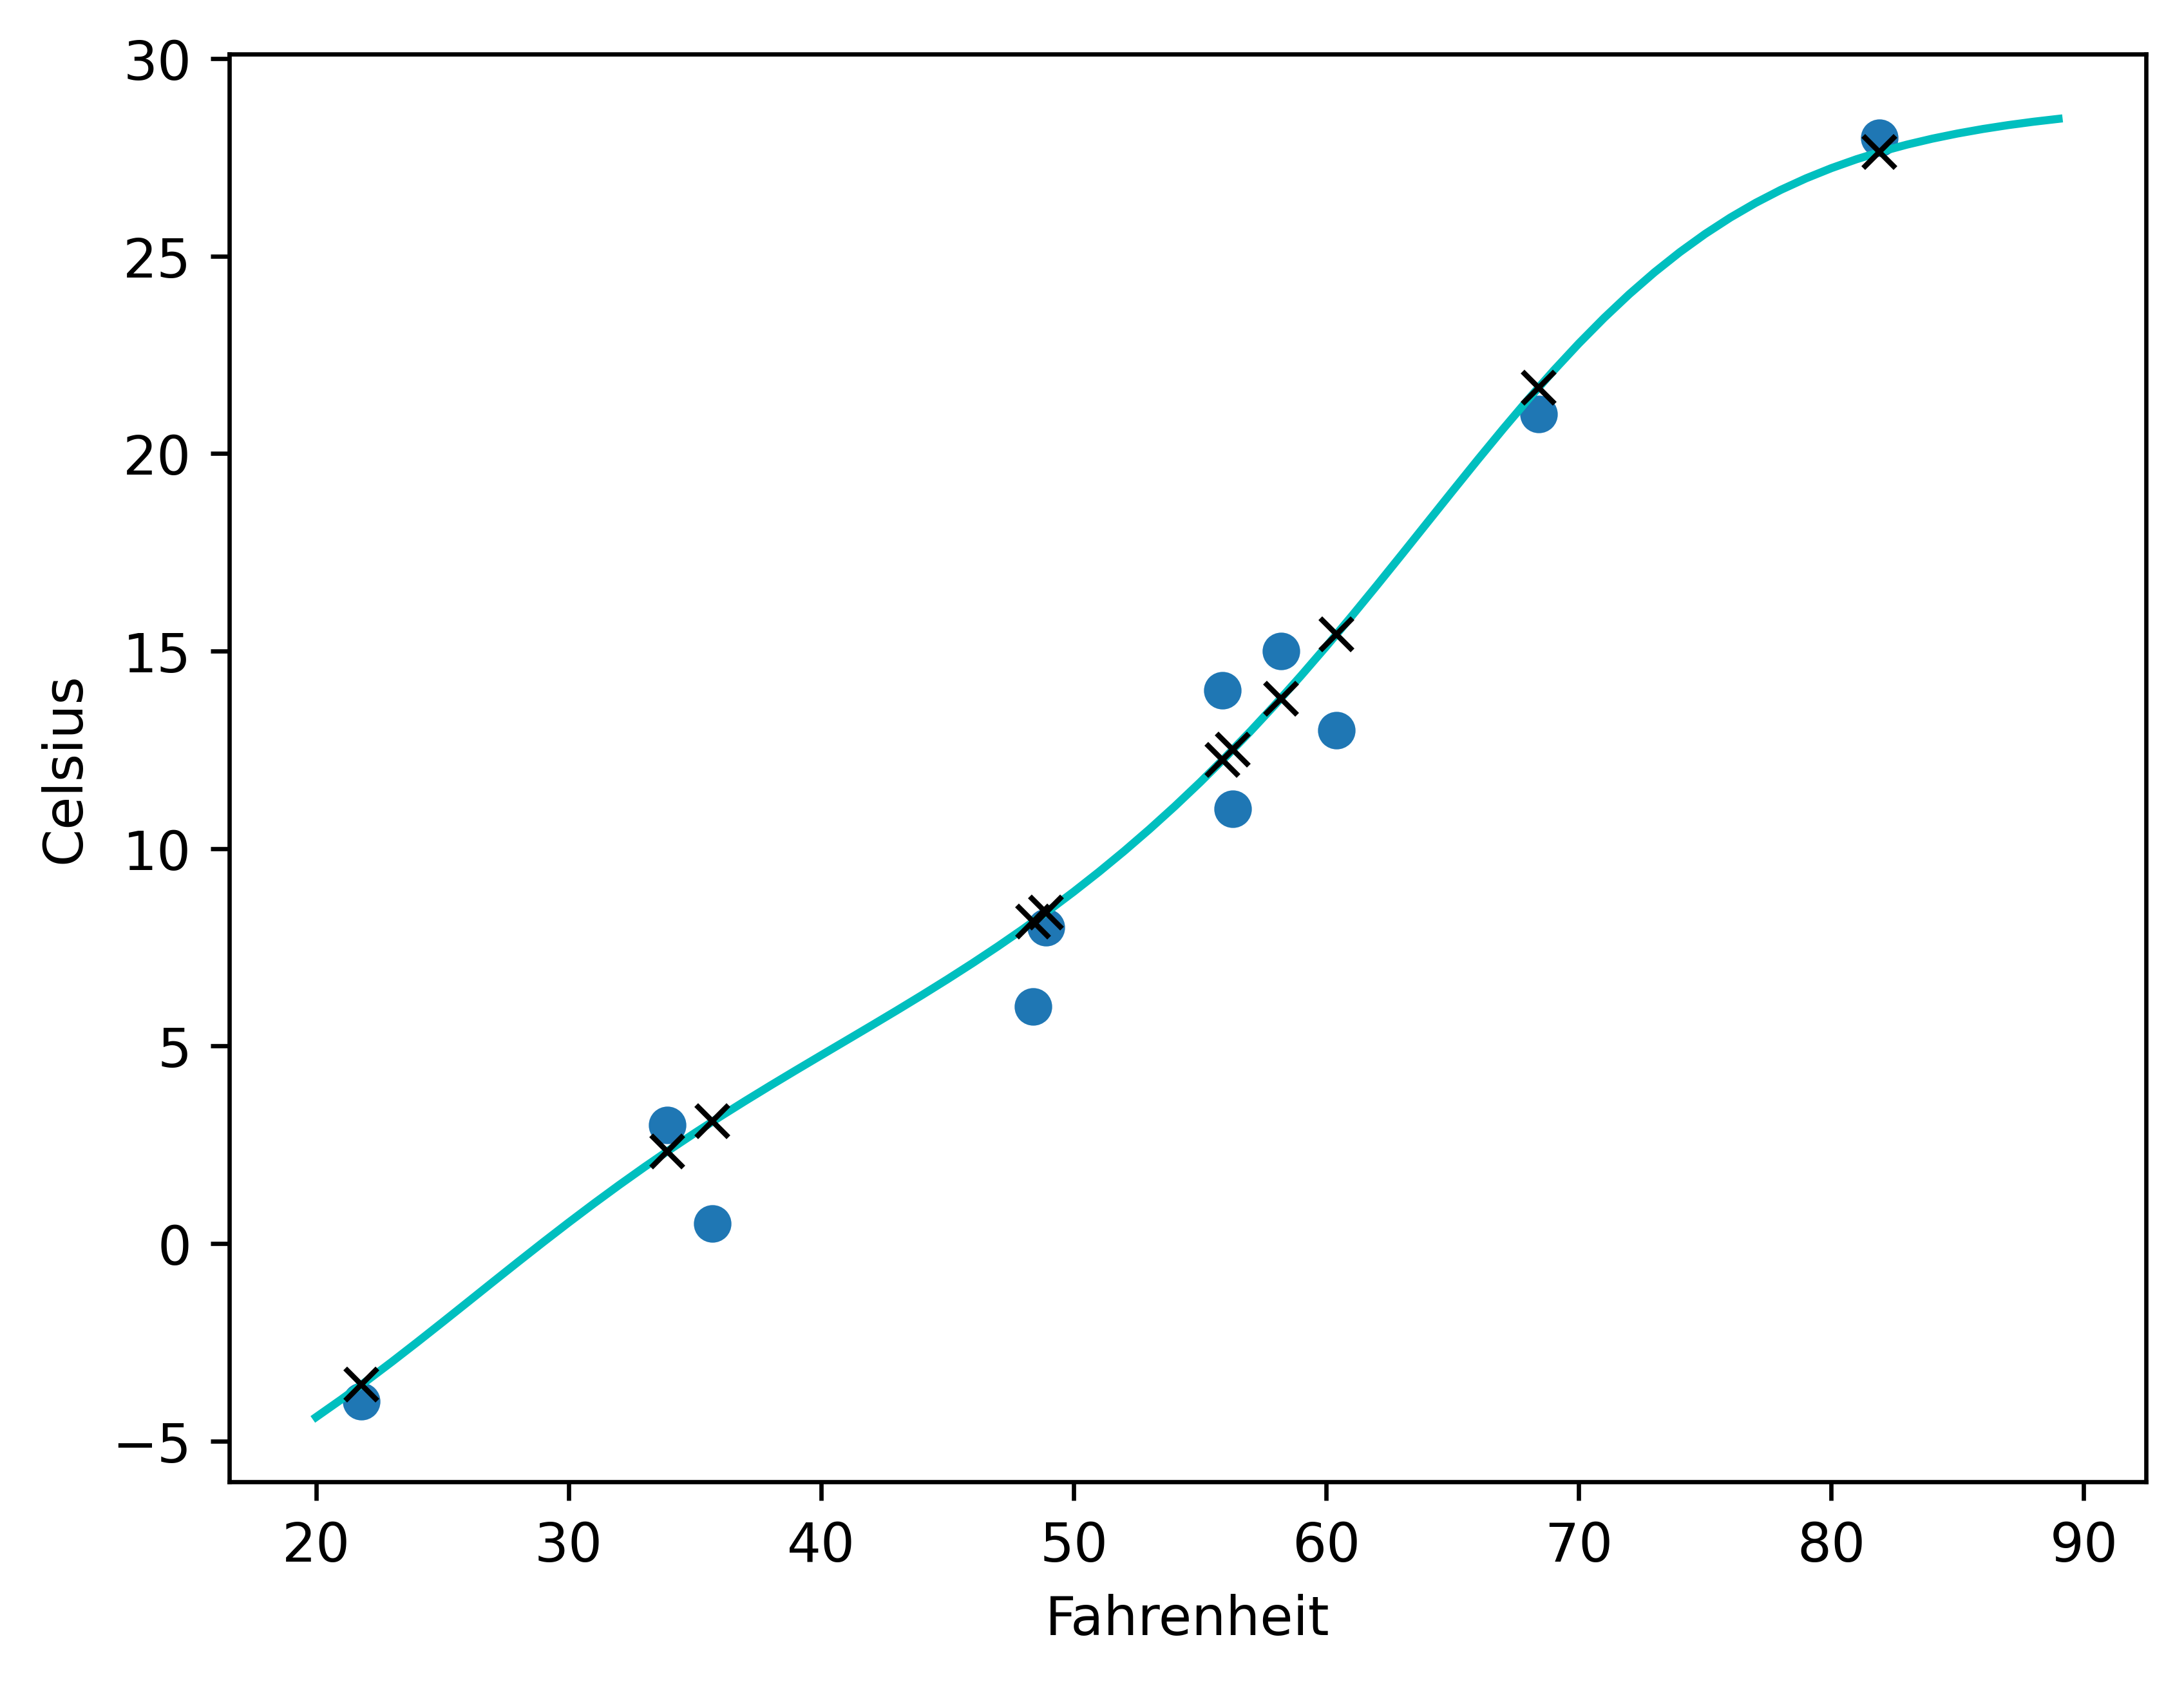

In [62]:
# 간단한 신경망 모델에서 여러 은닉층 뉴런과 학습률로 실험해보라
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1)
t_u = torch.tensor(t_u).unsqueeze(1)

n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val


def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val, t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train)
        loss_train = loss_fn(t_p_train, t_c_train)

        t_p_val = model(t_u_val)
        loss_val = loss_fn(t_p_val, t_c_val)

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")


seq_model = nn.Sequential(OrderedDict([('hidden_linear', nn.Linear(1, 4)),
                                       ('hidden_activation', nn.Tanh()),
                                       ('output_linear', nn.Linear(4, 1))]))
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)

training_loop(n_epochs = 5000,
              optimizer = optimizer,
              model = seq_model,
              loss_fn = nn.MSELoss(),
              t_u_train = t_un_train,
              t_u_val = t_un_val,
              t_c_train = t_c_train,
              t_c_val = t_c_val)


t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=600)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')

In [63]:
# a. 어떤 값을 바꿀 때 모델의 출력이 더욱 선형이 되었나?
# 입출력 피처의 수를 늘릴수록 이상적인 선형이 나옴 (1, 100), (100, 1) / lr=1e-3

In [64]:
# b. 확실하게 과적합하는 모델을 만들 수 있는가?
# (1, 4), (4, 1) / lr=1e-3

In [74]:
# 2. 4장의 와인 데이터 읽어서 적당한 수의 입력 파라미터를 가지는 모델을 만들어라
wine_path = '../winequality-white.csv'
wineq_numpy = np.loadtxt(wine_path, dtype=np.float32, delimiter=';', skiprows=1)
col_list = next(csv.reader(open(wine_path), delimiter=';'))
wineq = torch.from_numpy(wineq_numpy)

data = wineq[:, :-1]
target = wineq[:, -1]

t_c = torch.tensor(target).unsqueeze(1)
t_u = torch.tensor(data).unsqueeze(1)

n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

<ipython-input-74-066381e05c4a>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_c = torch.tensor(target).unsqueeze(1)
<ipython-input-74-066381e05c4a>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_u = torch.tensor(data).unsqueeze(1)


In [77]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val, t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train)
        loss_train = loss_fn(t_p_train, t_c_train)

        t_p_val = model(t_u_val)
        loss_val = loss_fn(t_p_val, t_c_val)

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        if epoch == 1 or epoch % 500 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")

In [78]:
seq_model = nn.Sequential(OrderedDict([('hidden_linear', nn.Linear(11, 4)), # 3919개 데이터가 11개의 열 가지므로 입력 피처는 11
                                       ('hidden_activation', nn.Tanh()),
                                       ('output_linear', nn.Linear(4, 1))]))
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)

training_loop(n_epochs = 5000,
              optimizer = optimizer,
              model = seq_model,
              loss_fn = nn.MSELoss(),
              t_u_train = t_u_train,
              t_u_val = t_u_val,
              t_c_train = t_c_train,
              t_c_val = t_c_val)

Epoch 1, Training loss 23.9882, Validation loss 23.9727
Epoch 500, Training loss 0.7764, Validation loss 0.8367
Epoch 1000, Training loss 0.7749, Validation loss 0.8372
Epoch 1500, Training loss 0.7746, Validation loss 0.8372
Epoch 2000, Training loss 0.7744, Validation loss 0.8372
Epoch 2500, Training loss 0.7742, Validation loss 0.8372
Epoch 3000, Training loss 0.7741, Validation loss 0.8372
Epoch 3500, Training loss 0.7740, Validation loss 0.8372
Epoch 4000, Training loss 0.7739, Validation loss 0.8372
Epoch 4500, Training loss 0.7738, Validation loss 0.8372
Epoch 5000, Training loss 0.7736, Validation loss 0.8372


In [79]:
# a. 앞에서 다룬 온도 데이터와 비교할 때 훈련 시간이 얼마나 더 오래 걸리는가? 훨씬 많이 대략 10~15분 정도 걸린 것으로 예상됨
# b. 어떤 요소가 훈련 시간에 영향을 주는지 설명할 수 있는가? 총 데이터 수와 입력 피처 수
# c. 데이터셋으로 훈련시키는 동안 손실이 줄어들었는가?
# d. 데이터셋을 어떻게 그래프로 표현할 것인가? 입력 피처가 너무 많아(11개) 그리기 힘들 것으로 생각됨